# Goals

This notebook aims to demonstrate the usage of multimodal model like GPT-4o on a video processing use-case.
The scenario is a user taking in video multiple receipts in order to automatically add them in his expense report system. 
It aims to take a video, processes it in multiples frames, pass these frames to a multimodal model (GPT-4o in our case) and extract key information such as date, merchant name, total amount and currency of the receipt. This multimodal model has the capability of identifying which tool (or "function") to use in this particular case which is adding the expense to our report system.

Once the right function needs to be called, it captures the required arguments for the function to be executed. 

We send arguments to the python function that processes receipts informations to input them in a dataframe (but you can integrate directly any API to insert these information to your expense report system), and returns the result that the model will interprets to provide a final answer (e.g. *'The following expenses have been succesfully to your expense report system'*)

In [65]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
from IPython.display import display, HTML, Image
import pandas as pd
import json
import base64

load_dotenv("azure.env")
    
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-05-01-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_API_BASE")
)

In [66]:
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import Image, display, Markdown
import time
import base64

VIDEO_PATH = "data/expense.MOV"

In [67]:
def process_video(video_path, seconds_per_frame=2):
    base64Frames = []
    base_video_path, _ = os.path.splitext(video_path)

    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    curr_frame=0

    # Loop through the video and extract frames at specified sampling rate
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    video.release()

    print(f"Extracted {len(base64Frames)} frames")
    return base64Frames

# Extract 1 frame per second. You can adjust the `seconds_per_frame` parameter to change the sampling rate
base64Frames = process_video(VIDEO_PATH, seconds_per_frame=1)

Extracted 10 frames


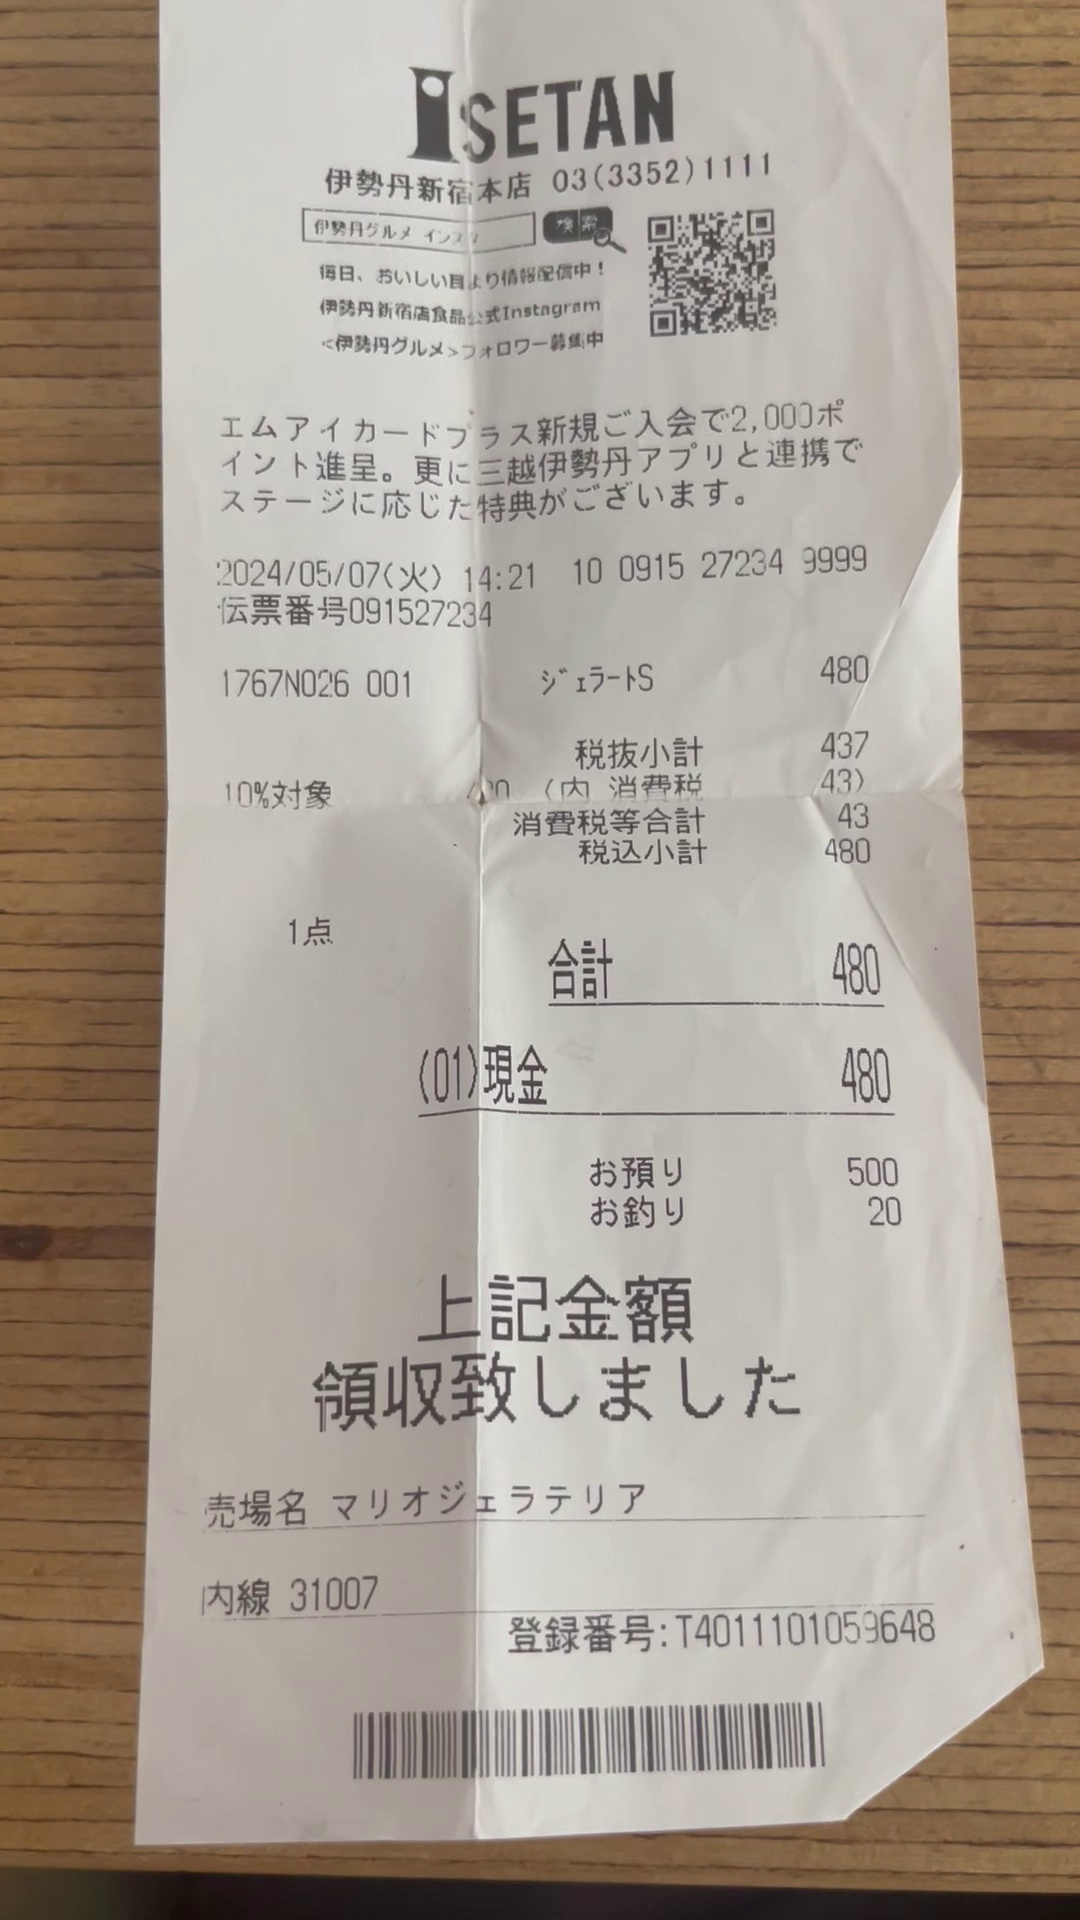

In [68]:
## Display the frames and audio for context
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8")), width=600))
    time.sleep(0.025)

In [73]:
import functools

report_df = pd.DataFrame(columns=['date', 'merchant_name', 'total_amount', 'currency'])

def add_expense_to_report(report_df, merchant_name, total_amount, currency, date):
    new_row = {
        'merchant_name': merchant_name,
        'total_amount': total_amount,
        'currency': currency,
        'date': date
    }
    report_df.loc[len(report_df)] = new_row
    return json.dumps({"message": "Expense added to report with the following information {date}, {merchant_name}, {total_amount} {currency}."})
    
def run_conversation():
    messages = [
        {"role": "system", "content": 
        f"""
        You are an expense report assistant, equipped to analyze expense information from receipts.
        Based on the user's request and the images you have, use your tools (e.g. add an expense) to assist the user.
        Respond in same language as the user (e.g. if user ask question in french, answer in french).
        """},
        {"role": "user", "content": [
            # "Please process my expenses.",
            *map(lambda x: {"type": "image_url", "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)],
        }
    ]
    tools = [
        {
            "type": "function",
            "function": {
                "name": "add_expense_to_report",
                "description": f"""
                    Add an expense filled with information provided in the receipt that are the date (MM-YYYY), the amount of the receipt, the currency of the expense, and the merchant name.
                    """,
                "parameters": {
                    "type": "object",
                    "properties": {
                        "date": {
                            "type": "string",
                            "description": "The date of the expense in european format (DD-MM-YYYY)."
                        },
                        "total_amount": {
                            "type": "string",
                            "description": "The amount of the receipt (without the currency as this is done in another parameter)e.g. 12.5."
                        },
                        "currency": {
                            "type": "string",
                            "description": "The currency of the amount e.g. EUR, USD, GBP, JPY, etc."
                        },
                        "merchant_name": {
                            "type": "string",
                            "description": "The category of the expense report e.g. 'Customer workshop 24 June 2024'."
                        }
                    },
                    "required": ["date", "total_amount", "currency", "merchant_name"]
                },
            },
        }
    ]
    names_to_functions = {
        "add_expense_to_report": functools.partial(add_expense_to_report, report_df=report_df)
    }

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=tools,
        tool_choice="auto",
        temperature=0
    )
    # Process the model's response
    response_message = response.choices[0].message
    messages.append(response_message)

    print("Model's response:")  
    print(response_message)  
    # Step 2: check if the model wanted to call a function

    # Handle function calls
    if response_message.tool_calls:
        for tool_call in response_message.tool_calls:
            function_name = tool_call.function.name
            function_args = json.loads(tool_call.function.arguments)
            print(f"Function call: {function_name}")  
            print(f"Function arguments: {function_args}")  
            
            if function_name == "add_expense_to_report":
                function_response = names_to_functions[function_name](**function_args)
            else:
                function_response = json.dumps({"error": "Unknown function"})
            
            messages.append({
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            })
    else:
        print("No tool calls were made by the model.")

    # Second API call: Get the final response from the model
    final_response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
    )
    report_df
    return final_response.choices[0].message.content

# Run the conversation and print the result
print(run_conversation())
report_df

Model's response:
ChatCompletionMessage(content='', role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_P2GAvEMYc9BEI7rIaVSEaAYk', function=Function(arguments='{"date": "23-06-2024", "total_amount": "23.43", "currency": "EUR", "merchant_name": "Boucherie du Marche"}', name='add_expense_to_report'), type='function'), ChatCompletionMessageToolCall(id='call_HLo2UlGRZmsWT7bZbL7mFiit', function=Function(arguments='{"date": "24-06-2024", "total_amount": "42.50", "currency": "EUR", "merchant_name": "Cafe des Federations"}', name='add_expense_to_report'), type='function'), ChatCompletionMessageToolCall(id='call_YMMmkSIYSEUVZ97qzXJmqLft', function=Function(arguments='{"date": "24-06-2024", "total_amount": "18.50", "currency": "EUR", "merchant_name": "Comptoir de l\'Industrie"}', name='add_expense_to_report'), type='function'), ChatCompletionMessageToolCall(id='call_V6fpHluLAQB5jQLjk91M5vZ6', function=Function(arguments='{"date": "07-05-2024", "total_amount":

,date,merchant_name,total_amount,currency
0,23-06-2024,Boucherie du Marche,23.43,EUR
1,24-06-2024,Cafe des Federations,42.50,EUR
2,24-06-2024,Comptoir de l'Industrie,18.50,EUR
3,07-05-2024,Isetan,480,JPY
